In [ ]:
# Compute JDPF of the product
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd 
import sys 
sys.path.append("/Odyssey/private/t22picar/tools/")
from plot_tools import plot_uv_map,plot_map_zoom,plot_map_multizoom
from R_tools_theo import * 
import matplotlib.colors as colors
# 2d hist 
import scipy.stats as st
import pandas as pd

def plot_jpdf(vrt,strain):

    binx = np.arange(-1,1.025,0.025)
    biny = np.arange(0,1.0125,0.0125)

    H_sum, xedges, yedges, _ = st.binned_statistic_2d(vrt.ravel(),strain.ravel(),vrt.ravel(),\
                    'count', bins=[binx, biny])

    fig = plt.figure(figsize=(20,10))

    list_proba = [99.9,99,98,90]

    H_norm = H_sum/np.sum(H_sum)
    ax = fig.add_subplot(1,1,1)
    #plt.title(gap_list[i],size=20)

    plt.pcolormesh(xedges[:],yedges[:],H_norm.T,norm=colors.LogNorm(vmin=1e-6, vmax=1e-1),cmap=plt.cm.Reds)
    cbar = plt.colorbar()
    cbar.set_label('Density', fontsize=22)
    cbar.ax.tick_params(labelsize=16)

    xedges=(xedges[1:]+xedges[:-1])/2
    yedges=(yedges[1:]+yedges[:-1])/2
    #CS = plt.contour(xedges[1:],yedges[1:],H_sum.T,linewidths=2,alpha=1,colors='k',linestyles='-')

    level,fmt = add_contour_per(H_sum.T,list_proba,xedges,yedges,c='k')
    CS = plt.contour(xedges,yedges,H_sum.T,level,linewidths=2,alpha=1,colors='k',linestyles='-')

    plt.clabel(CS,level, inline=1, fontsize=18,fmt = fmt)
    

In [2]:
def compute_strain_vrt(xp_name,time_target):

    #time_target='2019-06-30'

    if xp_name=="duacs_15m_8th":
        result_filepath =  f"/Odyssey/private/t22picar/multivar_drifter/rec/{xp_name}/daily/duacs_15m_8th_{time_target}.nc"
    else:
        result_filepath =  f"/Odyssey/private/t22picar/multivar_drifter/rec/{xp_name}/daily/unet_rec_{time_target}.nc"

    duacs = xr.open_dataset(result_filepath)

    if "lat" in duacs.coords:
        duacs = duacs.rename({"lat": "latitude"})
    if "lon" in duacs.coords:
        duacs = duacs.rename({"lon": "longitude"})

    #duacs
    duacs = duacs.sel(latitude=slice(-70,70))


    # Masquer les valeurs entre -10 et 10 de latitude
    duacs = duacs.where(
        (duacs.latitude < -10) | (duacs.latitude > 10),
        np.nan  # Remplace par NaN si la condition n'est pas remplie
    )

    u=duacs.ugos.values.T
    v=duacs.vgos.values.T


    #lon, lat = np.meshgrid(duacs.lon.values, duacs.lat.values)
    lon, lat = np.meshgrid(duacs.longitude.values, duacs.latitude.values)

    dx = sphere_distance(lat[:, :-1], lat[:, 1:], lon[:, :-1], lon[:, 1:]).T
    dy = sphere_distance(lat[:-1, :], lat[1:, :], lon[:-1, :], lon[1:, :]).T


    pm = u2rho(1 / dx)
    pn = v2rho(1 / dy)
    f = compute_coriolis_factor(lat).T

    # Compute Strain 
    strain =  get_strain(rho2u(u),rho2v(v),pm,pn) / np.abs(f)

    # Compute Vorticity
    vrt =  psi2rho(get_vrt(rho2u(u),rho2v(v),pm,pn)) / np.abs(f)

    return strain, vrt, lon, lat, u, v 

In [ ]:
date_range[0]

Timestamp('2019-01-01 00:00:00')

In [79]:
# For each day

# Génère une plage de dates quotidiennes entre '2019-01-01' et '2019-12-31'
date_range = pd.date_range(start='2019-01-01', end='2019-12-31', freq='D').strftime('%Y-%m-%d').tolist()

xp_name = "unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_duacs_RonanUnet"

list_rmse = []
list_strain = []
list_vrt = []

#time_target=date_range[0]
for time_target in date_range:

    # Get drifter data
    #print(time_target)
    result_filepath = "/Odyssey/private/t22picar/data/drifters/daily_uv/drifters_uv_aoml_15m_4th.nc"
    drifters = xr.open_dataset(result_filepath).sel(time=time_target).sel(lat=slice(-70,70))
    u_drifters=drifters.u_drifter.values.T
    v_drifters=drifters.v_drifter.values.T
    #print("u drifter loaded")

    #Get U,V, strain and vrt
    strain, vrt, lon, lat, u, v = compute_strain_vrt(xp_name,time_target)
    #print("strain and vrt computed")

    # Compute RMSE at drifter loc 
    rmse = ((u_drifters-u)**2 + (v_drifters-v)**2)
    #print("rmse computed")

    # Make a list (RMSE, strain, vrt) 

    mask = (~np.isnan(rmse)) & (~np.isnan(strain))

    rmse_filtred = rmse[mask].tolist()
    strain = strain[mask].tolist()
    vrt = vrt[mask].tolist()

    # Concat the list 
    list_rmse.append(rmse_filtred)
    list_strain.append(strain)
    list_vrt.append(vrt)


list_rmse = [item for sublist in list_rmse for item in sublist]
list_strain = [item for sublist in list_strain for item in sublist]
list_vrt = [item for sublist in list_vrt for item in sublist]

list_rmse=np.array(list_rmse).ravel()
list_strain=np.array(list_strain).ravel()
list_vrt=np.array(list_vrt).ravel()



In [83]:
#JPDF conditionned wc
binx = np.arange(-1,1.05,0.05)
biny = np.arange(0,1.025,0.025)

H_rmse, xedges, yedges, _ = st.binned_statistic_2d(list_vrt,list_strain,list_rmse,\
'mean', bins=[binx, biny])
#H_rmse = np.rot90(H_rmse); H_wc_d_t = np.flipud(H_rmse)

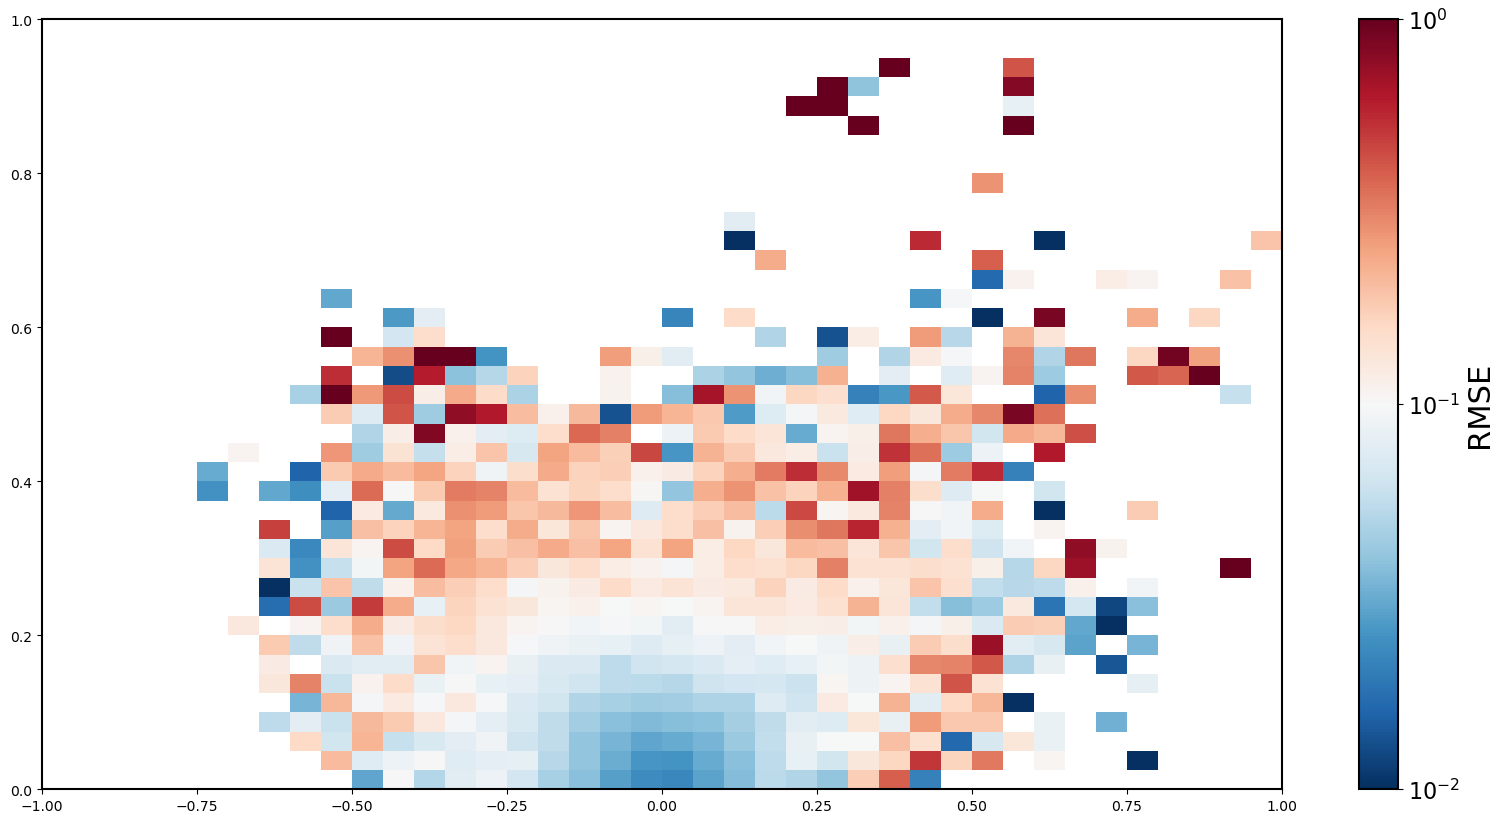

In [85]:

fig = plt.figure(figsize=(20,10))

#list_proba = [99.9,99,98,90]

ax = fig.add_subplot(1,1,1)
#plt.title(gap_list[i],size=20)

plt.pcolormesh(xedges[:],yedges[:],H_rmse.T,cmap=plt.cm.RdBu_r,norm=colors.SymLogNorm(linthresh=1e-3, linscale=1e-2,
                                                       vmin=1e-2, vmax=1))
cbar = plt.colorbar()
cbar.set_label('RMSE', fontsize=22)
cbar.ax.tick_params(labelsize=16)


In [ ]:
fig = plt.figure(figsize=(20,12))
#plt.title(month,size=20)
plt.axis('off')

xedges = np.arange(-6,6.05,0.05)
yedges = np.arange(0,6.025,0.025)

list_proba = proba_list = [99.90]


for i in range(gap_list.shape[0]-1):
    
    ax = fig.add_subplot(4,5,20-i)
    
    CS = plt.contour(xedges[1:],yedges[1:],H_sum,level,linewidths=2,alpha=1,colors='k',linestyles='-')
    
    
    H_w_sum = np.nanmean(H_w[:,:,i,:],axis=2)
    H_w_sum = np.where(H_sum < level,0,H_w_sum)
    
    plt.title(title_jpdf[i],size=20)
    #ax.set_aspect('equal', 'box')
    cf = plt.pcolormesh(xedges[:],yedges[:],H_w_sum,cmap=plt.cm.RdBu_r,norm=colors.SymLogNorm(linthresh=1e1, linscale=1,
                                                       vmin=-1e3, vmax=1e3))
    x = np.linspace(0, 6, 100)
    x = np.linspace(0, 6, 100)
    x1 = np.linspace(0, 0.5, 100)
    plt.plot(x1,x1,linestyle='-.',color='grey')
    plt.plot(-x,x,linestyle='-.',color='grey')
    plt.vlines(0.5,0.5,6,linestyle='-.',color='navy',alpha=0.9)
    x_sub = np.linspace(0.5, 6, 100)
    plt.plot(x_sub,x_sub,linestyle='-.',color='navy',alpha=0.9)

    plt.vlines(-0.5,0.5,6,linestyle='-.',color='darkred',alpha=0.9)
    x_sub = np.linspace(0.5, 6, 100)
    plt.plot(-x_sub,x_sub,linestyle='-.',color='darkred',alpha=0.9)

    plt.xlim(-2,4.5)
    plt.ylim(0,6)